In [1]:
import csv
import os
from math import log10, inf
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
class Kind(Enum):
    Acc = 'accuracy.csv'
    Mem = 'mem-ideal.csv'
    Perf = 'perf.csv'
    Per_particle = 'per-particles.csv'
    Per_step = 'per-step.csv'
    Per_step_mem = 'per-step-mem.csv'
    Perf_step = 'perf-step.csv'
    
class Algo(Enum):
    # DS = 'ds_nogc'
    BDS = 'ds_bounded'
    SDS = 'ds'
    PF = 'particles'
    
class Example(Enum):
    BetaBernoulli = 'coin'
    Gaussian = 'gaussian'
    Kalman = 'kalman'
    Outlier = 'outlier'
    Robot = 'tracker'
    Slam = 'slam'
    Mtt = 'mtt'
    
class Data:
    def __init__(self, example, algo, kind):
        self.filename = os.path.join('..', example.value, algo.value, kind.value)
        self.file = None
        
    def __enter__(self):
        self.file = open(self.filename, 'r')
        header = [h.strip() for h in self.file.readline().split(',')]
        return csv.DictReader(self.file, fieldnames=header, quoting=csv.QUOTE_NONNUMERIC)
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.file.close()

In [3]:
def get_baseline(example, algo=Algo.SDS, particles=500):
    with Data(example, algo, Kind.Acc) as accuracy:
        return next(row['median'] for row in accuracy if row['particles'] == particles)

In [4]:
def get_crossing_point(example, algo, baseline={}):
    b_acc = get_baseline(example, **baseline)
    with Data(example, algo, Kind.Acc) as accuracy:
        cond = lambda x: abs(log10(x) - log10(b_acc)) <= 0.5
        return next(row['particles'] for row in accuracy if cond(row['upper quantile']))

In [5]:
def get_perf(example, algo, baseline={}):
    crossing_point = get_crossing_point(example, algo, baseline)
    with Data(example, algo, Kind.Perf) as perf:
        return next((crossing_point, row['time in ms lower quantile'], row['median'], row['upper quantile'])
                     for row in perf if row['particles'] == crossing_point)

In [6]:
def get_results(baseline={}):
    res = {}
    for algo in Algo:
        res[algo.name] = {
            'particles': [], 
            'mean': [],
            'lower': [], 
            'upper': []
            }
        for example in Example:
            try:
                (particles, lower, mean, upper) = get_perf(example, algo, baseline)
            except (StopIteration, IOError):
                (particles, lower, mean, upper) = 0, 0, 0, 0
            res[algo.name]['particles'].append(particles)
            res[algo.name]['lower'].append(lower)
            res[algo.name]['mean'].append(mean)
            res[algo.name]['upper'].append(upper)
    return res

In [7]:
def plot(results): 
    barWidth = 0.25
 
    bars1 = results['PF']['mean']
    bars2 = results['BDS']['mean']
    bars3 = results['SDS']['mean']
 
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
 
    plt.bar(r1, bars1, width=barWidth, edgecolor='white', alpha=0.75)
    plt.bar(r2, bars2, width=barWidth, edgecolor='white', alpha=0.75)
    plt.bar(r3, bars3, width=barWidth, edgecolor='white', alpha=0.75)
 
    plt.xticks([r + barWidth for r in range(len(bars1))], [ex.name for ex in Example])
    plt.yscale('log')
    plt.xticks(rotation=30)
    
    plt.show()

{'BDS': [200.0, 750.0, 1.0, 65.0, 8.0, 0, 0],
 'PF': [200.0, 3000.0, 15.0, 650.0, 85.0, 0, 0],
 'SDS': [1.0, 150.0, 1.0, 65.0, 1.0, 700.0, 0]}


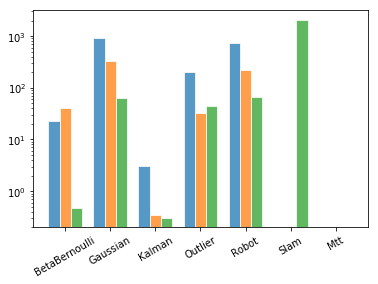

In [8]:
results = get_results()
pprint({algo: results[algo]['particles'] for algo in results})
plot(results)

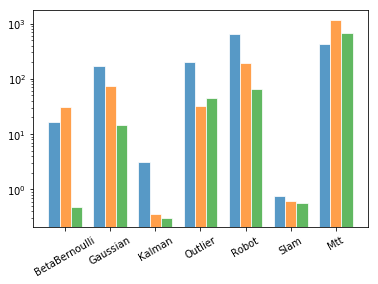

In [9]:
plot(get_results({'algo': Algo.PF, 'particles': 1000}))

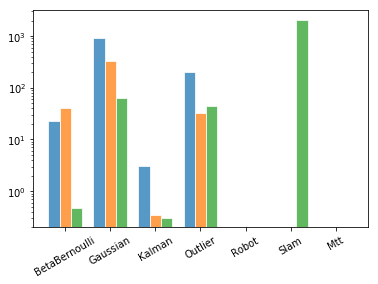

In [10]:
plot(get_results({'algo': Algo.PF, 'particles': 10000}))